In [1]:
import cv2
import tqdm
import os
os.chdir('/vol/medic01/users/bh1511/PyCharm_Deployment/ResNetAE')
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import time

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from ResNetAE import ResNetVQVAE


In [2]:
##### ChestXray14 ######################################################################################################

# This code uses the NIH Chest Xray dataset with labels from Luigi Saetta:
# https://nihcc.app.box.com/v/ChestXray-NIHCC
# https://github.com/luigisaetta/cxr-anomaly-detection

# data_root           = '/vol/biomedic/users/bh1511/datasets/cxr/ChestXray-NIHCC/images/'
data_root           = '/data/datasets/chest_xray/ChestXray-NIHCC/images/'

train_df            = pd.read_csv('nih_data_split/train.txt', delimiter=' ', header=None)
val_df              = pd.read_csv('nih_data_split/val.txt', delimiter=' ', header=None)
test_df             = pd.read_csv('nih_data_split/test_attending_rad.txt', delimiter=' ', header=None)

train_normal_pth    = data_root + train_df.loc[train_df[1]==0][0]
train_abnormal_pth  = data_root + train_df.loc[train_df[1]==1][0]
val_normal_pth      = data_root + val_df.loc[val_df[1]==0][0]
val_abnormal_pth    = data_root + val_df.loc[val_df[1]==1][0]
test_normal_pth     = data_root + test_df.loc[test_df[1]==0][0]
test_abnormal_pth   = data_root + test_df.loc[test_df[1]==1][0]


In [3]:
##### HParams ##########################################################################################################

NUM_LATENT_K = 512                # Number of codebook entries
NUM_LATENT_D = 128 # 64           # Dimension of each codebook entries
BETA = 0.25                       # Weight for the commitment loss

INPUT_SHAPE = (256, 256, 1)
SIZE = 16                         # Spatial size of latent embedding

VQVAE_BATCH_SIZE = 16             # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 100            # Number of epochs
VQVAE_LEARNING_RATE = 1e-4        # Learning rate

SAVE_DIR = 'checkpoint_nih_healthy_3'

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 500         # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12*4        # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32*2  # Width of each PixelCNN block

LOAD_MODEL = False


In [4]:
##### Tensorflow Dataset ###############################################################################################

def parse_function(filename):
    # Read entire contents of image
    image_string = tf.io.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.io.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize image with padding to 256x256
    image = tf.image.resize_with_pad(image, 256, 256, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)

    return image

train_ds = tf.data.Dataset.from_tensor_slices((train_normal_pth))
train_ds = train_ds.shuffle(len(train_ds))
train_ds = train_ds.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(VQVAE_BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((val_normal_pth))
val_ds = val_ds.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(VQVAE_BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((test_abnormal_pth))
test_ds = test_ds.map(parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(VQVAE_BATCH_SIZE)


In [5]:
##### Define Model, Optimizer and Loss #################################################################################

model = ResNetVQVAE(input_shape=INPUT_SHAPE,
                    vq_num_embeddings=NUM_LATENT_K,
                    vq_embedding_dim=NUM_LATENT_D,
                    vq_commiment_cost=BETA)

optimizer = tf.keras.optimizers.Adam(learning_rate=VQVAE_LEARNING_RATE)
mse_loss = tf.keras.losses.MSE

train_total_loss = tf.keras.metrics.Mean()
train_VecQuant_loss = tf.keras.metrics.Mean()
train_reconstruction_loss = tf.keras.metrics.Mean()

val_total_loss = tf.keras.metrics.Mean()
val_VecQuant_loss = tf.keras.metrics.Mean()
val_reconstruction_loss = tf.keras.metrics.Mean()


In [6]:
##### ResNetVQVAE Training Loop ########################################################################################

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        vq_loss, data_recon, perplexity, encodings = model(data)
        recon_err = mse_loss(data_recon, data)
        loss = vq_loss + recon_err

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_total_loss(loss)
    train_reconstruction_loss(recon_err)
    train_VecQuant_loss(vq_loss)

@tf.function
def val_step(data):
    vq_loss, data_recon, perplexity, encodings = model(data)
    recon_err = mse_loss(data_recon, data)
    loss = vq_loss + recon_err

    val_total_loss(loss)
    val_reconstruction_loss(recon_err)
    val_VecQuant_loss(vq_loss)

for epoch in range(VQVAE_NUM_EPOCHS):

    train_total_loss.reset_states()
    train_reconstruction_loss.reset_states()
    train_VecQuant_loss.reset_states()

    val_total_loss.reset_states()
    val_reconstruction_loss.reset_states()
    val_VecQuant_loss.reset_states()

    print('=' * 50, f'Training EPOCH {epoch}', '=' * 50)
    start = time.time()

    ## Train Step
    t = tqdm.tqdm(enumerate(train_ds), total=len(train_ds))
    for step, data in t:
        train_step(data)
        t.set_description('>%d, t_loss=%.5f, recon_loss=%.5f, VecQuant_loss=%.5f' % (step,
                                                                                     train_total_loss.result(),
                                                                                     train_reconstruction_loss.result(),
                                                                                     train_VecQuant_loss.result()))

    ## Evaluation Step
    for step, data in tqdm.tqdm(enumerate(val_ds), total=len(val_ds)):
        val_step(data)

    print(f'Epoch {epoch} complete in: {time.time() - start:.5f}')
    print('t_loss={:.5f}, recon_loss={:.5f}, VecQuant_loss={:.5f}'.format(val_total_loss.result(),
                                                                          val_reconstruction_loss.result(),
                                                                          val_VecQuant_loss.result()))

    model.save_weights(os.path.join(SAVE_DIR, f'model_{epoch}.h5'))


================================================== Training EPOCH 0 ==================================================


>266, t_loss=58.69121, recon_loss=0.08229, VecQuant_loss=58.46094: 100%|██████████| 267/267 [02:17<00:00,  1.95it/s]  
100%|██████████| 54/54 [00:09<00:00,  5.99it/s]


Epoch 0 complete in: 146.62478
t_loss=1.06399, recon_loss=0.02436, VecQuant_loss=1.03405


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 1 ==================================================


>266, t_loss=0.84663, recon_loss=0.01833, VecQuant_loss=0.82789: 100%|██████████| 267/267 [01:46<00:00,  2.52it/s]
100%|██████████| 54/54 [00:05<00:00,  9.67it/s]


Epoch 1 complete in: 111.83486
t_loss=0.61312, recon_loss=0.01556, VecQuant_loss=0.59438


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 2 ==================================================


>266, t_loss=0.49412, recon_loss=0.01431, VecQuant_loss=0.47966: 100%|██████████| 267/267 [01:46<00:00,  2.50it/s]
100%|██████████| 54/54 [00:05<00:00,  9.53it/s]


Epoch 2 complete in: 112.61921
t_loss=0.35390, recon_loss=0.01346, VecQuant_loss=0.33895


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 3 ==================================================


>266, t_loss=0.31259, recon_loss=0.01297, VecQuant_loss=0.29947: 100%|██████████| 267/267 [01:48<00:00,  2.46it/s]
100%|██████████| 54/54 [00:05<00:00,  9.06it/s]


Epoch 3 complete in: 114.61646
t_loss=0.25359, recon_loss=0.01372, VecQuant_loss=0.23895


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 4 ==================================================


>266, t_loss=0.22906, recon_loss=0.01190, VecQuant_loss=0.21709: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:06<00:00,  8.98it/s]


Epoch 4 complete in: 118.58694
t_loss=0.19158, recon_loss=0.01313, VecQuant_loss=0.17789


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 5 ==================================================


>266, t_loss=0.17733, recon_loss=0.01114, VecQuant_loss=0.16613: 100%|██████████| 267/267 [01:51<00:00,  2.40it/s]
100%|██████████| 54/54 [00:05<00:00,  9.12it/s]


Epoch 5 complete in: 117.09355
t_loss=0.14611, recon_loss=0.01076, VecQuant_loss=0.13508


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 6 ==================================================


>266, t_loss=0.13820, recon_loss=0.00979, VecQuant_loss=0.12838: 100%|██████████| 267/267 [01:50<00:00,  2.42it/s]
100%|██████████| 54/54 [00:05<00:00,  9.12it/s]


Epoch 6 complete in: 116.33366
t_loss=0.11530, recon_loss=0.00951, VecQuant_loss=0.10570


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 7 ==================================================


>266, t_loss=0.10882, recon_loss=0.00872, VecQuant_loss=0.10004: 100%|██████████| 267/267 [01:49<00:00,  2.43it/s]
100%|██████████| 54/54 [00:05<00:00,  9.26it/s]


Epoch 7 complete in: 115.64303
t_loss=0.09325, recon_loss=0.00938, VecQuant_loss=0.08389


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 8 ==================================================


>266, t_loss=0.08790, recon_loss=0.00788, VecQuant_loss=0.07997: 100%|██████████| 267/267 [01:51<00:00,  2.40it/s]
100%|██████████| 54/54 [00:05<00:00,  9.03it/s]


Epoch 8 complete in: 117.51177
t_loss=0.07613, recon_loss=0.00750, VecQuant_loss=0.06873


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 9 ==================================================


>266, t_loss=0.07381, recon_loss=0.00724, VecQuant_loss=0.06656: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:06<00:00,  8.99it/s]


Epoch 9 complete in: 118.59334
t_loss=0.06432, recon_loss=0.00704, VecQuant_loss=0.05741


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 10 ==================================================


>266, t_loss=0.06324, recon_loss=0.00683, VecQuant_loss=0.05638: 100%|██████████| 267/267 [01:53<00:00,  2.35it/s]
100%|██████████| 54/54 [00:06<00:00,  8.94it/s]


Epoch 10 complete in: 119.91696
t_loss=0.05531, recon_loss=0.00649, VecQuant_loss=0.04896


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 11 ==================================================


>266, t_loss=0.05506, recon_loss=0.00643, VecQuant_loss=0.04863: 100%|██████████| 267/267 [01:53<00:00,  2.34it/s]
100%|██████████| 54/54 [00:06<00:00,  9.00it/s]


Epoch 11 complete in: 120.06324
t_loss=0.04879, recon_loss=0.00602, VecQuant_loss=0.04292


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 12 ==================================================


>266, t_loss=0.04887, recon_loss=0.00605, VecQuant_loss=0.04286: 100%|██████████| 267/267 [01:54<00:00,  2.33it/s]
100%|██████████| 54/54 [00:06<00:00,  8.98it/s]


Epoch 12 complete in: 120.79261
t_loss=0.04380, recon_loss=0.00566, VecQuant_loss=0.03830


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 13 ==================================================


>266, t_loss=0.04436, recon_loss=0.00584, VecQuant_loss=0.03852: 100%|██████████| 267/267 [01:54<00:00,  2.34it/s]
100%|██████████| 54/54 [00:06<00:00,  8.94it/s]


Epoch 13 complete in: 120.23502
t_loss=0.04025, recon_loss=0.00554, VecQuant_loss=0.03488


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 14 ==================================================


>266, t_loss=0.04063, recon_loss=0.00562, VecQuant_loss=0.03499: 100%|██████████| 267/267 [01:54<00:00,  2.34it/s]
100%|██████████| 54/54 [00:06<00:00,  8.90it/s]


Epoch 14 complete in: 120.25303
t_loss=0.03749, recon_loss=0.00555, VecQuant_loss=0.03210


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 15 ==================================================


>266, t_loss=0.03763, recon_loss=0.00548, VecQuant_loss=0.03214: 100%|██████████| 267/267 [01:54<00:00,  2.34it/s]
100%|██████████| 54/54 [00:06<00:00,  8.95it/s]


Epoch 15 complete in: 120.31703
t_loss=0.03469, recon_loss=0.00524, VecQuant_loss=0.02961


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 16 ==================================================


>266, t_loss=0.03502, recon_loss=0.00530, VecQuant_loss=0.02971: 100%|██████████| 267/267 [01:54<00:00,  2.34it/s]
100%|██████████| 54/54 [00:06<00:00,  8.88it/s]


Epoch 16 complete in: 120.32700
t_loss=0.03271, recon_loss=0.00514, VecQuant_loss=0.02772


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 17 ==================================================


>266, t_loss=0.03289, recon_loss=0.00517, VecQuant_loss=0.02771: 100%|██████████| 267/267 [01:54<00:00,  2.33it/s]
100%|██████████| 54/54 [00:06<00:00,  8.72it/s]


Epoch 17 complete in: 120.65994
t_loss=0.03112, recon_loss=0.00571, VecQuant_loss=0.02559


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 18 ==================================================


>266, t_loss=0.03107, recon_loss=0.00504, VecQuant_loss=0.02602: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.05it/s]


Epoch 18 complete in: 119.32624
t_loss=0.02906, recon_loss=0.00488, VecQuant_loss=0.02434


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 19 ==================================================


>266, t_loss=0.02935, recon_loss=0.00491, VecQuant_loss=0.02444: 100%|██████████| 267/267 [01:50<00:00,  2.41it/s]
100%|██████████| 54/54 [00:05<00:00,  9.09it/s]


Epoch 19 complete in: 116.75185
t_loss=0.02777, recon_loss=0.00467, VecQuant_loss=0.02326


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 20 ==================================================


>266, t_loss=0.02788, recon_loss=0.00477, VecQuant_loss=0.02310: 100%|██████████| 267/267 [01:49<00:00,  2.44it/s]
100%|██████████| 54/54 [00:05<00:00,  9.23it/s]


Epoch 20 complete in: 115.58343
t_loss=0.02604, recon_loss=0.00455, VecQuant_loss=0.02166


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 21 ==================================================


>266, t_loss=0.02661, recon_loss=0.00462, VecQuant_loss=0.02198: 100%|██████████| 267/267 [01:50<00:00,  2.41it/s]
100%|██████████| 54/54 [00:06<00:00,  8.95it/s]


Epoch 21 complete in: 116.95453
t_loss=0.02482, recon_loss=0.00442, VecQuant_loss=0.02056


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 22 ==================================================


>266, t_loss=0.02552, recon_loss=0.00455, VecQuant_loss=0.02097: 100%|██████████| 267/267 [01:52<00:00,  2.38it/s]
100%|██████████| 54/54 [00:06<00:00,  8.98it/s]


Epoch 22 complete in: 118.30149
t_loss=0.02385, recon_loss=0.00426, VecQuant_loss=0.01975


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 23 ==================================================


>266, t_loss=0.02446, recon_loss=0.00440, VecQuant_loss=0.02007: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:06<00:00,  8.99it/s]


Epoch 23 complete in: 118.93987
t_loss=0.02323, recon_loss=0.00429, VecQuant_loss=0.01910


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 24 ==================================================


>266, t_loss=0.02360, recon_loss=0.00433, VecQuant_loss=0.01926: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:06<00:00,  8.85it/s]


Epoch 24 complete in: 118.90150
t_loss=0.02218, recon_loss=0.00409, VecQuant_loss=0.01824


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 25 ==================================================


>266, t_loss=0.02263, recon_loss=0.00420, VecQuant_loss=0.01843: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.91it/s]


Epoch 25 complete in: 119.36442
t_loss=0.02210, recon_loss=0.00441, VecQuant_loss=0.01782


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 26 ==================================================


>266, t_loss=0.02191, recon_loss=0.00414, VecQuant_loss=0.01776: 100%|██████████| 267/267 [01:53<00:00,  2.35it/s]
100%|██████████| 54/54 [00:06<00:00,  8.88it/s]


Epoch 26 complete in: 119.63151
t_loss=0.02108, recon_loss=0.00425, VecQuant_loss=0.01698


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 27 ==================================================


>266, t_loss=0.02122, recon_loss=0.00405, VecQuant_loss=0.01717: 100%|██████████| 267/267 [01:52<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.01it/s]


Epoch 27 complete in: 119.03391
t_loss=0.02013, recon_loss=0.00384, VecQuant_loss=0.01642


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 28 ==================================================


>266, t_loss=0.02055, recon_loss=0.00409, VecQuant_loss=0.01646: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.14it/s]


Epoch 28 complete in: 119.34457
t_loss=0.01936, recon_loss=0.00398, VecQuant_loss=0.01551


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 29 ==================================================


>266, t_loss=0.01961, recon_loss=0.00387, VecQuant_loss=0.01574: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.09it/s]


Epoch 29 complete in: 119.19718
t_loss=0.01858, recon_loss=0.00376, VecQuant_loss=0.01495


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 30 ==================================================


>266, t_loss=0.01905, recon_loss=0.00382, VecQuant_loss=0.01523: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.13it/s]


Epoch 30 complete in: 119.05632
t_loss=0.01861, recon_loss=0.00386, VecQuant_loss=0.01488


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 31 ==================================================


>266, t_loss=0.01848, recon_loss=0.00377, VecQuant_loss=0.01471: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.05it/s]


Epoch 31 complete in: 118.79061
t_loss=0.01772, recon_loss=0.00381, VecQuant_loss=0.01402


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 32 ==================================================


>266, t_loss=0.01772, recon_loss=0.00367, VecQuant_loss=0.01404: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.83it/s]


Epoch 32 complete in: 119.46628
t_loss=0.01676, recon_loss=0.00348, VecQuant_loss=0.01339


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 33 ==================================================


>266, t_loss=0.01733, recon_loss=0.00365, VecQuant_loss=0.01367: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.98it/s]


Epoch 33 complete in: 119.36888
t_loss=0.01707, recon_loss=0.00373, VecQuant_loss=0.01345


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 34 ==================================================


>266, t_loss=0.01659, recon_loss=0.00354, VecQuant_loss=0.01304: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.92it/s]


Epoch 34 complete in: 119.22833
t_loss=0.01573, recon_loss=0.00333, VecQuant_loss=0.01251


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 35 ==================================================


>266, t_loss=0.01614, recon_loss=0.00349, VecQuant_loss=0.01265: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.07it/s]


Epoch 35 complete in: 118.67525
t_loss=0.01531, recon_loss=0.00328, VecQuant_loss=0.01213


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 36 ==================================================


>266, t_loss=0.01554, recon_loss=0.00339, VecQuant_loss=0.01215: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.06it/s]


Epoch 36 complete in: 119.12192
t_loss=0.01575, recon_loss=0.00349, VecQuant_loss=0.01235


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 37 ==================================================


>266, t_loss=0.01518, recon_loss=0.00335, VecQuant_loss=0.01183: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.01it/s]


Epoch 37 complete in: 119.12487
t_loss=0.01442, recon_loss=0.00316, VecQuant_loss=0.01137


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 38 ==================================================


>266, t_loss=0.01472, recon_loss=0.00328, VecQuant_loss=0.01144: 100%|██████████| 267/267 [01:52<00:00,  2.38it/s]
100%|██████████| 54/54 [00:05<00:00,  9.09it/s]


Epoch 38 complete in: 118.42721
t_loss=0.01377, recon_loss=0.00313, VecQuant_loss=0.01074


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 39 ==================================================


>266, t_loss=0.01424, recon_loss=0.00322, VecQuant_loss=0.01103: 100%|██████████| 267/267 [01:52<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.07it/s]


Epoch 39 complete in: 118.97378
t_loss=0.01384, recon_loss=0.00340, VecQuant_loss=0.01053


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 40 ==================================================


>266, t_loss=0.01378, recon_loss=0.00311, VecQuant_loss=0.01068: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.03it/s]


Epoch 40 complete in: 119.14457
t_loss=0.01342, recon_loss=0.00330, VecQuant_loss=0.01022


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 41 ==================================================


>266, t_loss=0.01348, recon_loss=0.00311, VecQuant_loss=0.01037: 100%|██████████| 267/267 [01:52<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.04it/s]


Epoch 41 complete in: 119.01546
t_loss=0.01306, recon_loss=0.00328, VecQuant_loss=0.00986


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 42 ==================================================


>266, t_loss=0.01320, recon_loss=0.00305, VecQuant_loss=0.01015: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.95it/s]


Epoch 42 complete in: 119.17557
t_loss=0.01210, recon_loss=0.00285, VecQuant_loss=0.00933


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 43 ==================================================


>266, t_loss=0.01252, recon_loss=0.00295, VecQuant_loss=0.00957: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.00it/s]


Epoch 43 complete in: 119.22654
t_loss=0.01245, recon_loss=0.00290, VecQuant_loss=0.00963


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 44 ==================================================


>266, t_loss=0.01210, recon_loss=0.00289, VecQuant_loss=0.00922: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.91it/s]


Epoch 44 complete in: 119.23718
t_loss=0.01146, recon_loss=0.00275, VecQuant_loss=0.00879


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 45 ==================================================


>266, t_loss=0.01166, recon_loss=0.00282, VecQuant_loss=0.00885: 100%|██████████| 267/267 [01:52<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.97it/s]


Epoch 45 complete in: 119.02171
t_loss=0.01101, recon_loss=0.00268, VecQuant_loss=0.00840


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 46 ==================================================


>266, t_loss=0.01134, recon_loss=0.00277, VecQuant_loss=0.00857: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:06<00:00,  8.97it/s]


Epoch 46 complete in: 118.99100
t_loss=0.01073, recon_loss=0.00266, VecQuant_loss=0.00813


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 47 ==================================================


>266, t_loss=0.01085, recon_loss=0.00270, VecQuant_loss=0.00815: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.04it/s]


Epoch 47 complete in: 118.87652
t_loss=0.01037, recon_loss=0.00270, VecQuant_loss=0.00772


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 48 ==================================================


>266, t_loss=0.01050, recon_loss=0.00265, VecQuant_loss=0.00785: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.08it/s]


Epoch 48 complete in: 118.82631
t_loss=0.00977, recon_loss=0.00252, VecQuant_loss=0.00730


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 49 ==================================================


>266, t_loss=0.01000, recon_loss=0.00254, VecQuant_loss=0.00746: 100%|██████████| 267/267 [01:53<00:00,  2.36it/s]
100%|██████████| 54/54 [00:05<00:00,  9.14it/s]


Epoch 49 complete in: 119.31695
t_loss=0.00975, recon_loss=0.00262, VecQuant_loss=0.00718


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 50 ==================================================


>266, t_loss=0.00966, recon_loss=0.00249, VecQuant_loss=0.00716: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.01it/s]


Epoch 50 complete in: 118.72134
t_loss=0.00928, recon_loss=0.00240, VecQuant_loss=0.00692


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 51 ==================================================


>266, t_loss=0.00933, recon_loss=0.00244, VecQuant_loss=0.00689: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.02it/s]


Epoch 51 complete in: 118.67292
t_loss=0.00863, recon_loss=0.00232, VecQuant_loss=0.00636


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 52 ==================================================


>266, t_loss=0.00886, recon_loss=0.00239, VecQuant_loss=0.00648: 100%|██████████| 267/267 [01:51<00:00,  2.39it/s]
100%|██████████| 54/54 [00:06<00:00,  8.91it/s]


Epoch 52 complete in: 117.97172
t_loss=0.00842, recon_loss=0.00239, VecQuant_loss=0.00607


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 53 ==================================================


>266, t_loss=0.00851, recon_loss=0.00232, VecQuant_loss=0.00619: 100%|██████████| 267/267 [01:52<00:00,  2.37it/s]
100%|██████████| 54/54 [00:05<00:00,  9.11it/s]


Epoch 53 complete in: 118.64272
t_loss=0.00824, recon_loss=0.00225, VecQuant_loss=0.00604


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 54 ==================================================


>266, t_loss=0.00822, recon_loss=0.00228, VecQuant_loss=0.00594: 100%|██████████| 267/267 [01:51<00:00,  2.39it/s]
100%|██████████| 54/54 [00:05<00:00,  9.06it/s]


Epoch 54 complete in: 117.85105
t_loss=0.00792, recon_loss=0.00221, VecQuant_loss=0.00575


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 55 ==================================================


>266, t_loss=0.00783, recon_loss=0.00220, VecQuant_loss=0.00564: 100%|██████████| 267/267 [01:52<00:00,  2.38it/s]
100%|██████████| 54/54 [00:06<00:00,  8.97it/s]


Epoch 55 complete in: 118.49977
t_loss=0.00753, recon_loss=0.00213, VecQuant_loss=0.00544


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 56 ==================================================


>266, t_loss=0.00759, recon_loss=0.00217, VecQuant_loss=0.00542: 100%|██████████| 267/267 [01:52<00:00,  2.38it/s]
100%|██████████| 54/54 [00:05<00:00,  9.06it/s]


Epoch 56 complete in: 118.47265
t_loss=0.00711, recon_loss=0.00205, VecQuant_loss=0.00509


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 57 ==================================================


>266, t_loss=0.00737, recon_loss=0.00212, VecQuant_loss=0.00525: 100%|██████████| 267/267 [01:51<00:00,  2.38it/s]
100%|██████████| 54/54 [00:06<00:00,  8.98it/s]


Epoch 57 complete in: 118.07745
t_loss=0.00752, recon_loss=0.00226, VecQuant_loss=0.00529


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 58 ==================================================


>266, t_loss=0.00714, recon_loss=0.00209, VecQuant_loss=0.00505: 100%|██████████| 267/267 [01:52<00:00,  2.38it/s]
100%|██████████| 54/54 [00:05<00:00,  9.08it/s]


Epoch 58 complete in: 118.23788
t_loss=0.00667, recon_loss=0.00199, VecQuant_loss=0.00471


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 59 ==================================================


>266, t_loss=0.00689, recon_loss=0.00203, VecQuant_loss=0.00486: 100%|██████████| 267/267 [01:51<00:00,  2.39it/s]
100%|██████████| 54/54 [00:05<00:00,  9.06it/s]


Epoch 59 complete in: 117.86050
t_loss=0.00662, recon_loss=0.00199, VecQuant_loss=0.00467


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 60 ==================================================


>266, t_loss=0.00674, recon_loss=0.00200, VecQuant_loss=0.00473: 100%|██████████| 267/267 [01:51<00:00,  2.39it/s]
100%|██████████| 54/54 [00:05<00:00,  9.06it/s]


Epoch 60 complete in: 117.69728
t_loss=0.00665, recon_loss=0.00201, VecQuant_loss=0.00466


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 61 ==================================================


>266, t_loss=0.00663, recon_loss=0.00199, VecQuant_loss=0.00465: 100%|██████████| 267/267 [01:51<00:00,  2.40it/s]
100%|██████████| 54/54 [00:05<00:00,  9.04it/s]


Epoch 61 complete in: 117.51774
t_loss=0.00617, recon_loss=0.00194, VecQuant_loss=0.00426


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 62 ==================================================


>266, t_loss=0.00643, recon_loss=0.00195, VecQuant_loss=0.00448: 100%|██████████| 267/267 [01:51<00:00,  2.39it/s]
100%|██████████| 54/54 [00:05<00:00,  9.17it/s]


Epoch 62 complete in: 117.59885
t_loss=0.00629, recon_loss=0.00190, VecQuant_loss=0.00442


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 63 ==================================================


>266, t_loss=0.00634, recon_loss=0.00192, VecQuant_loss=0.00442: 100%|██████████| 267/267 [01:51<00:00,  2.40it/s]
100%|██████████| 54/54 [00:05<00:00,  9.05it/s]


Epoch 63 complete in: 117.28460
t_loss=0.00629, recon_loss=0.00192, VecQuant_loss=0.00441


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 64 ==================================================


>266, t_loss=0.00618, recon_loss=0.00189, VecQuant_loss=0.00429: 100%|██████████| 267/267 [01:51<00:00,  2.39it/s]
100%|██████████| 54/54 [00:05<00:00,  9.09it/s]


Epoch 64 complete in: 117.53304
t_loss=0.00617, recon_loss=0.00187, VecQuant_loss=0.00433


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 65 ==================================================


>266, t_loss=0.00614, recon_loss=0.00187, VecQuant_loss=0.00427: 100%|██████████| 267/267 [01:51<00:00,  2.40it/s]
100%|██████████| 54/54 [00:05<00:00,  9.19it/s]


Epoch 65 complete in: 117.18674
t_loss=0.00614, recon_loss=0.00206, VecQuant_loss=0.00411


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 66 ==================================================


>266, t_loss=0.00598, recon_loss=0.00184, VecQuant_loss=0.00414: 100%|██████████| 267/267 [01:51<00:00,  2.40it/s]
100%|██████████| 54/54 [00:06<00:00,  8.85it/s]


Epoch 66 complete in: 117.61168
t_loss=0.00603, recon_loss=0.00187, VecQuant_loss=0.00418


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 67 ==================================================


>266, t_loss=0.00587, recon_loss=0.00182, VecQuant_loss=0.00405: 100%|██████████| 267/267 [01:52<00:00,  2.36it/s]
100%|██████████| 54/54 [00:06<00:00,  8.95it/s]


Epoch 67 complete in: 119.03277
t_loss=0.00576, recon_loss=0.00179, VecQuant_loss=0.00399


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 68 ==================================================


>266, t_loss=0.00578, recon_loss=0.00179, VecQuant_loss=0.00399: 100%|██████████| 267/267 [01:53<00:00,  2.35it/s]
100%|██████████| 54/54 [00:06<00:00,  8.84it/s]


Epoch 68 complete in: 119.88003
t_loss=0.00571, recon_loss=0.00178, VecQuant_loss=0.00397


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 69 ==================================================


>266, t_loss=0.00568, recon_loss=0.00179, VecQuant_loss=0.00390: 100%|██████████| 267/267 [01:54<00:00,  2.33it/s]
100%|██████████| 54/54 [00:06<00:00,  8.89it/s]


Epoch 69 complete in: 120.79054
t_loss=0.00610, recon_loss=0.00209, VecQuant_loss=0.00403


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 70 ==================================================


>266, t_loss=0.00563, recon_loss=0.00177, VecQuant_loss=0.00386: 100%|██████████| 267/267 [01:55<00:00,  2.32it/s]
100%|██████████| 54/54 [00:06<00:00,  8.72it/s]


Epoch 70 complete in: 121.63543
t_loss=0.00529, recon_loss=0.00172, VecQuant_loss=0.00359


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 71 ==================================================


>266, t_loss=0.00553, recon_loss=0.00174, VecQuant_loss=0.00379: 100%|██████████| 267/267 [01:56<00:00,  2.30it/s]
100%|██████████| 54/54 [00:06<00:00,  8.76it/s]


Epoch 71 complete in: 122.56287
t_loss=0.00551, recon_loss=0.00182, VecQuant_loss=0.00372


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 72 ==================================================


>266, t_loss=0.00548, recon_loss=0.00173, VecQuant_loss=0.00375: 100%|██████████| 267/267 [01:56<00:00,  2.29it/s]
100%|██████████| 54/54 [00:06<00:00,  8.69it/s]


Epoch 72 complete in: 122.97289
t_loss=0.00526, recon_loss=0.00176, VecQuant_loss=0.00353


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 73 ==================================================


>266, t_loss=0.00539, recon_loss=0.00171, VecQuant_loss=0.00368: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.75it/s]


Epoch 73 complete in: 123.33887
t_loss=0.00535, recon_loss=0.00175, VecQuant_loss=0.00362


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 74 ==================================================


>266, t_loss=0.00534, recon_loss=0.00170, VecQuant_loss=0.00364: 100%|██████████| 267/267 [01:56<00:00,  2.30it/s]
100%|██████████| 54/54 [00:06<00:00,  8.78it/s]


Epoch 74 complete in: 122.49293
t_loss=0.00525, recon_loss=0.00165, VecQuant_loss=0.00363


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 75 ==================================================


>266, t_loss=0.00523, recon_loss=0.00166, VecQuant_loss=0.00356: 100%|██████████| 267/267 [01:55<00:00,  2.30it/s]
100%|██████████| 54/54 [00:06<00:00,  8.69it/s]


Epoch 75 complete in: 122.28003
t_loss=0.00517, recon_loss=0.00168, VecQuant_loss=0.00352


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 76 ==================================================


>266, t_loss=0.00521, recon_loss=0.00167, VecQuant_loss=0.00354: 100%|██████████| 267/267 [01:56<00:00,  2.29it/s]
100%|██████████| 54/54 [00:06<00:00,  8.55it/s]


Epoch 76 complete in: 122.89809
t_loss=0.00500, recon_loss=0.00164, VecQuant_loss=0.00339


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 77 ==================================================


>266, t_loss=0.00509, recon_loss=0.00164, VecQuant_loss=0.00345: 100%|██████████| 267/267 [01:56<00:00,  2.30it/s]
100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Epoch 77 complete in: 122.67995
t_loss=0.00505, recon_loss=0.00165, VecQuant_loss=0.00342


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 78 ==================================================


>266, t_loss=0.00510, recon_loss=0.00163, VecQuant_loss=0.00346: 100%|██████████| 267/267 [01:56<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.65it/s]


Epoch 78 complete in: 123.33379
t_loss=0.00496, recon_loss=0.00163, VecQuant_loss=0.00336


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 79 ==================================================


>266, t_loss=0.00498, recon_loss=0.00160, VecQuant_loss=0.00337: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.66it/s]


Epoch 79 complete in: 123.51395
t_loss=0.00480, recon_loss=0.00159, VecQuant_loss=0.00323


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 80 ==================================================


>266, t_loss=0.00494, recon_loss=0.00161, VecQuant_loss=0.00333: 100%|██████████| 267/267 [01:56<00:00,  2.29it/s]
100%|██████████| 54/54 [00:06<00:00,  8.52it/s]


Epoch 80 complete in: 123.01506
t_loss=0.00481, recon_loss=0.00159, VecQuant_loss=0.00325


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 81 ==================================================


>266, t_loss=0.00489, recon_loss=0.00159, VecQuant_loss=0.00330: 100%|██████████| 267/267 [01:56<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.72it/s]


Epoch 81 complete in: 123.19486
t_loss=0.00469, recon_loss=0.00155, VecQuant_loss=0.00316


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 82 ==================================================


>266, t_loss=0.00482, recon_loss=0.00157, VecQuant_loss=0.00325: 100%|██████████| 267/267 [01:57<00:00,  2.27it/s]
100%|██████████| 54/54 [00:06<00:00,  8.61it/s]


Epoch 82 complete in: 124.00726
t_loss=0.00472, recon_loss=0.00158, VecQuant_loss=0.00316


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 83 ==================================================


>266, t_loss=0.00480, recon_loss=0.00156, VecQuant_loss=0.00324: 100%|██████████| 267/267 [01:57<00:00,  2.27it/s]
100%|██████████| 54/54 [00:06<00:00,  8.66it/s]


Epoch 83 complete in: 123.79529
t_loss=0.00470, recon_loss=0.00156, VecQuant_loss=0.00316


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 84 ==================================================


>266, t_loss=0.00468, recon_loss=0.00154, VecQuant_loss=0.00314: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.48it/s]


Epoch 84 complete in: 123.73170
t_loss=0.00456, recon_loss=0.00155, VecQuant_loss=0.00303


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 85 ==================================================


>266, t_loss=0.00467, recon_loss=0.00154, VecQuant_loss=0.00314: 100%|██████████| 267/267 [01:56<00:00,  2.29it/s]
100%|██████████| 54/54 [00:06<00:00,  8.71it/s]


Epoch 85 complete in: 122.90340
t_loss=0.00456, recon_loss=0.00158, VecQuant_loss=0.00300


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 86 ==================================================


>266, t_loss=0.00460, recon_loss=0.00152, VecQuant_loss=0.00307: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.84it/s]


Epoch 86 complete in: 123.31175
t_loss=0.00483, recon_loss=0.00152, VecQuant_loss=0.00332


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 87 ==================================================


>266, t_loss=0.00455, recon_loss=0.00151, VecQuant_loss=0.00304: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Epoch 87 complete in: 123.62604
t_loss=0.00447, recon_loss=0.00162, VecQuant_loss=0.00287


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 88 ==================================================


>266, t_loss=0.00449, recon_loss=0.00150, VecQuant_loss=0.00299: 100%|██████████| 267/267 [01:56<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Epoch 88 complete in: 123.21366
t_loss=0.00438, recon_loss=0.00150, VecQuant_loss=0.00290


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 89 ==================================================


>266, t_loss=0.00445, recon_loss=0.00148, VecQuant_loss=0.00296: 100%|██████████| 267/267 [01:57<00:00,  2.27it/s]
100%|██████████| 54/54 [00:06<00:00,  8.52it/s]


Epoch 89 complete in: 124.07043
t_loss=0.00445, recon_loss=0.00159, VecQuant_loss=0.00288


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 90 ==================================================


>266, t_loss=0.00439, recon_loss=0.00148, VecQuant_loss=0.00291: 100%|██████████| 267/267 [01:57<00:00,  2.27it/s]
100%|██████████| 54/54 [00:06<00:00,  8.51it/s]


Epoch 90 complete in: 124.02680
t_loss=0.00423, recon_loss=0.00147, VecQuant_loss=0.00278


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 91 ==================================================


>266, t_loss=0.00436, recon_loss=0.00148, VecQuant_loss=0.00289: 100%|██████████| 267/267 [01:58<00:00,  2.26it/s]
100%|██████████| 54/54 [00:06<00:00,  8.24it/s]


Epoch 91 complete in: 125.01855
t_loss=0.00425, recon_loss=0.00149, VecQuant_loss=0.00278


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 92 ==================================================


>266, t_loss=0.00430, recon_loss=0.00145, VecQuant_loss=0.00285: 100%|██████████| 267/267 [01:58<00:00,  2.26it/s]
100%|██████████| 54/54 [00:06<00:00,  8.44it/s]


Epoch 92 complete in: 124.54563
t_loss=0.00417, recon_loss=0.00146, VecQuant_loss=0.00273


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 93 ==================================================


>266, t_loss=0.00429, recon_loss=0.00144, VecQuant_loss=0.00284: 100%|██████████| 267/267 [01:57<00:00,  2.27it/s]
100%|██████████| 54/54 [00:06<00:00,  8.77it/s]


Epoch 93 complete in: 123.95278
t_loss=0.00435, recon_loss=0.00154, VecQuant_loss=0.00282


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 94 ==================================================


>266, t_loss=0.00428, recon_loss=0.00145, VecQuant_loss=0.00283: 100%|██████████| 267/267 [01:56<00:00,  2.29it/s]
100%|██████████| 54/54 [00:06<00:00,  8.64it/s]


Epoch 94 complete in: 122.82225
t_loss=0.00414, recon_loss=0.00146, VecQuant_loss=0.00269


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 95 ==================================================


>266, t_loss=0.00423, recon_loss=0.00143, VecQuant_loss=0.00280: 100%|██████████| 267/267 [01:56<00:00,  2.29it/s]
100%|██████████| 54/54 [00:06<00:00,  8.90it/s]


Epoch 95 complete in: 122.62153
t_loss=0.00414, recon_loss=0.00144, VecQuant_loss=0.00271


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 96 ==================================================


>266, t_loss=0.00419, recon_loss=0.00143, VecQuant_loss=0.00276: 100%|██████████| 267/267 [01:56<00:00,  2.30it/s]
100%|██████████| 54/54 [00:06<00:00,  8.74it/s]


Epoch 96 complete in: 122.37842
t_loss=0.00427, recon_loss=0.00147, VecQuant_loss=0.00281


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 97 ==================================================


>266, t_loss=0.00416, recon_loss=0.00142, VecQuant_loss=0.00274: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.58it/s]


Epoch 97 complete in: 123.51234
t_loss=0.00428, recon_loss=0.00154, VecQuant_loss=0.00275


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 98 ==================================================


>266, t_loss=0.00414, recon_loss=0.00141, VecQuant_loss=0.00273: 100%|██████████| 267/267 [01:57<00:00,  2.28it/s]
100%|██████████| 54/54 [00:06<00:00,  8.73it/s]


Epoch 98 complete in: 123.44106
t_loss=0.00409, recon_loss=0.00142, VecQuant_loss=0.00268


  0%|          | 0/267 [00:00<?, ?it/s]

================================================== Training EPOCH 99 ==================================================


>266, t_loss=0.00408, recon_loss=0.00140, VecQuant_loss=0.00268: 100%|██████████| 267/267 [01:56<00:00,  2.30it/s]
100%|██████████| 54/54 [00:06<00:00,  8.54it/s]


Epoch 99 complete in: 122.63562
t_loss=0.00402, recon_loss=0.00143, VecQuant_loss=0.00260


  0%|          | 0/42 [00:00<?, ?it/s]

Running Inference


100%|██████████| 12/12 [00:00<00:00, 42.24it/s]


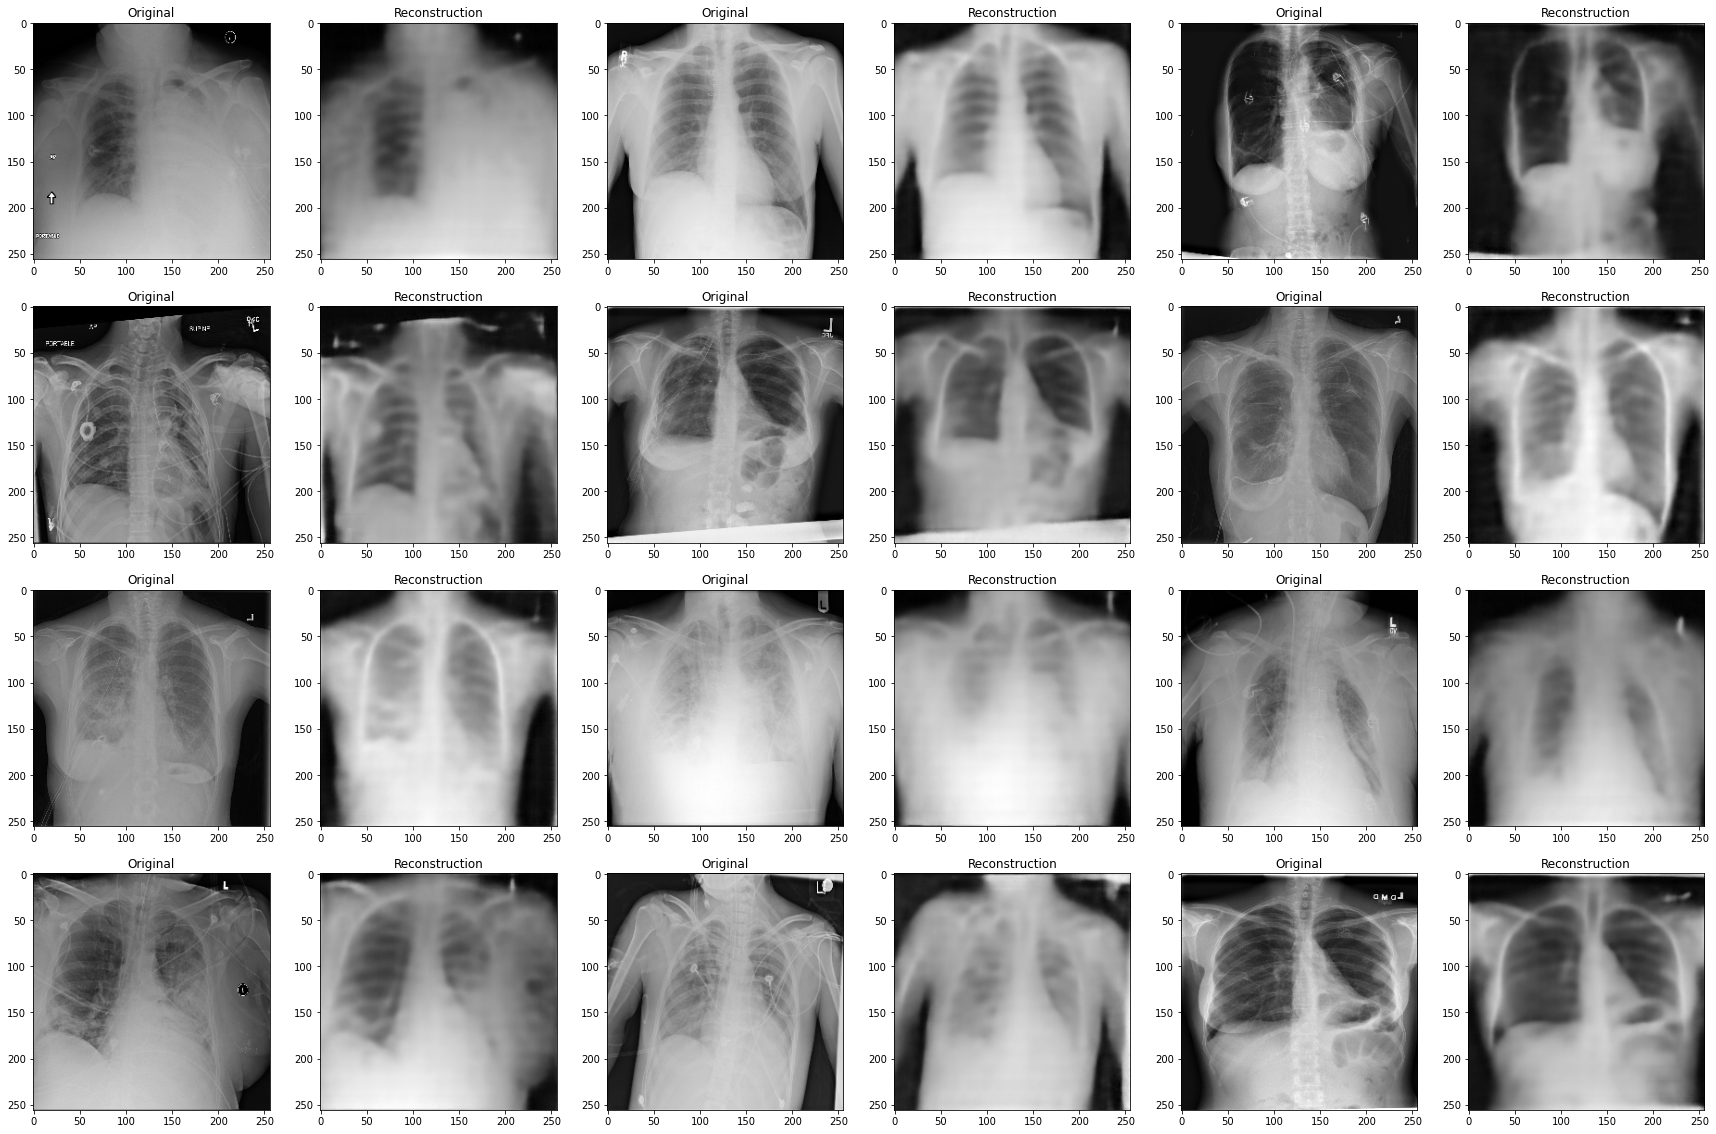

In [7]:
##### ResNetVQVAE Evaluation Loop ######################################################################################

if LOAD_MODEL:
    a=model(np.zeros((10,256,256,1)).astype('float32'))
    model.load_weights(os.path.join(SAVE_DIR, 'model_99.h5'))

## Inference
n_inference = 100
input_samples = []
output_samples = []
print('Running Inference')
for i, data in tqdm.tqdm(enumerate(test_ds), total=len(test_ds)):
    _, gen_sample, _, _ = model(data, training=False)
    gen_sample = gen_sample.numpy()
    input_samples.append(data)
    output_samples.append(gen_sample)
    # if i == n_inference: break

input_samples = np.concatenate(input_samples, axis=0)
output_samples = np.concatenate(output_samples, axis=0)

# assert os.path.exists(SAVE_DIR), "Directory does not exist"
# print('Saving Images')
# for i in tqdm.tqdm(range(n_inference)):
#     cv2.imwrite(os.path.join(SAVE_DIR, f'sample_{i}_real.jpg'), input_samples[i]*255.)
#     cv2.imwrite(os.path.join(SAVE_DIR, f'sample_{i}_gen.jpg'), output_samples[i]*255.)

fig = plt.figure(figsize=(30, 20))

rnd_idx = np.random.choice(input_samples.shape[0], size=[12], replace=False)
for i in tqdm.tqdm(range(12)):
    ax = fig.add_subplot(4, 6, i*2 + 1)
    ax.set_title('Original')
    ax.imshow(np.squeeze(input_samples[rnd_idx[i]]*255.), cmap='gray')
    ax = fig.add_subplot(4, 6, i*2 + 2)
    ax.set_title('Reconstruction')
    ax.imshow(np.squeeze(output_samples[rnd_idx[i]]*255.), cmap='gray')


In [8]:
##### Quantised Encodings ##############################################################################################

if LOAD_MODEL:
    a=model(np.zeros((10, 256, 256, 1)).astype('float32'))
    model.load_weights(os.path.join(SAVE_DIR, 'model_99.h5'))

z_train = []
for i, data in enumerate(tqdm.tqdm(train_ds)):
    encodings = model.vq_vae(model.pre_vq_conv(model.encoder(data)))[3]
    z_train.append(encodings)
    # if i == 100: break
z_train = np.concatenate(z_train, axis=0)

z_val = []
for i, data in enumerate(tqdm.tqdm(val_ds)):
    encodings = model.vq_vae(model.pre_vq_conv(model.encoder(data)))[3]
    z_val.append(encodings)
    # if i == 100: break
z_val = np.concatenate(z_val, axis=0)

z_test = []
for i, data in enumerate(tqdm.tqdm(test_ds)):
    encodings = model.vq_vae(model.pre_vq_conv(model.encoder(data)))[3]
    z_test.append(encodings)
    # if i == 100: break
z_test = np.concatenate(z_test, axis=0)


100%|██████████| 42/42 [00:04<00:00,  9.85it/s]


100%|██████████| 32/32 [00:00<00:00, 83.28it/s]


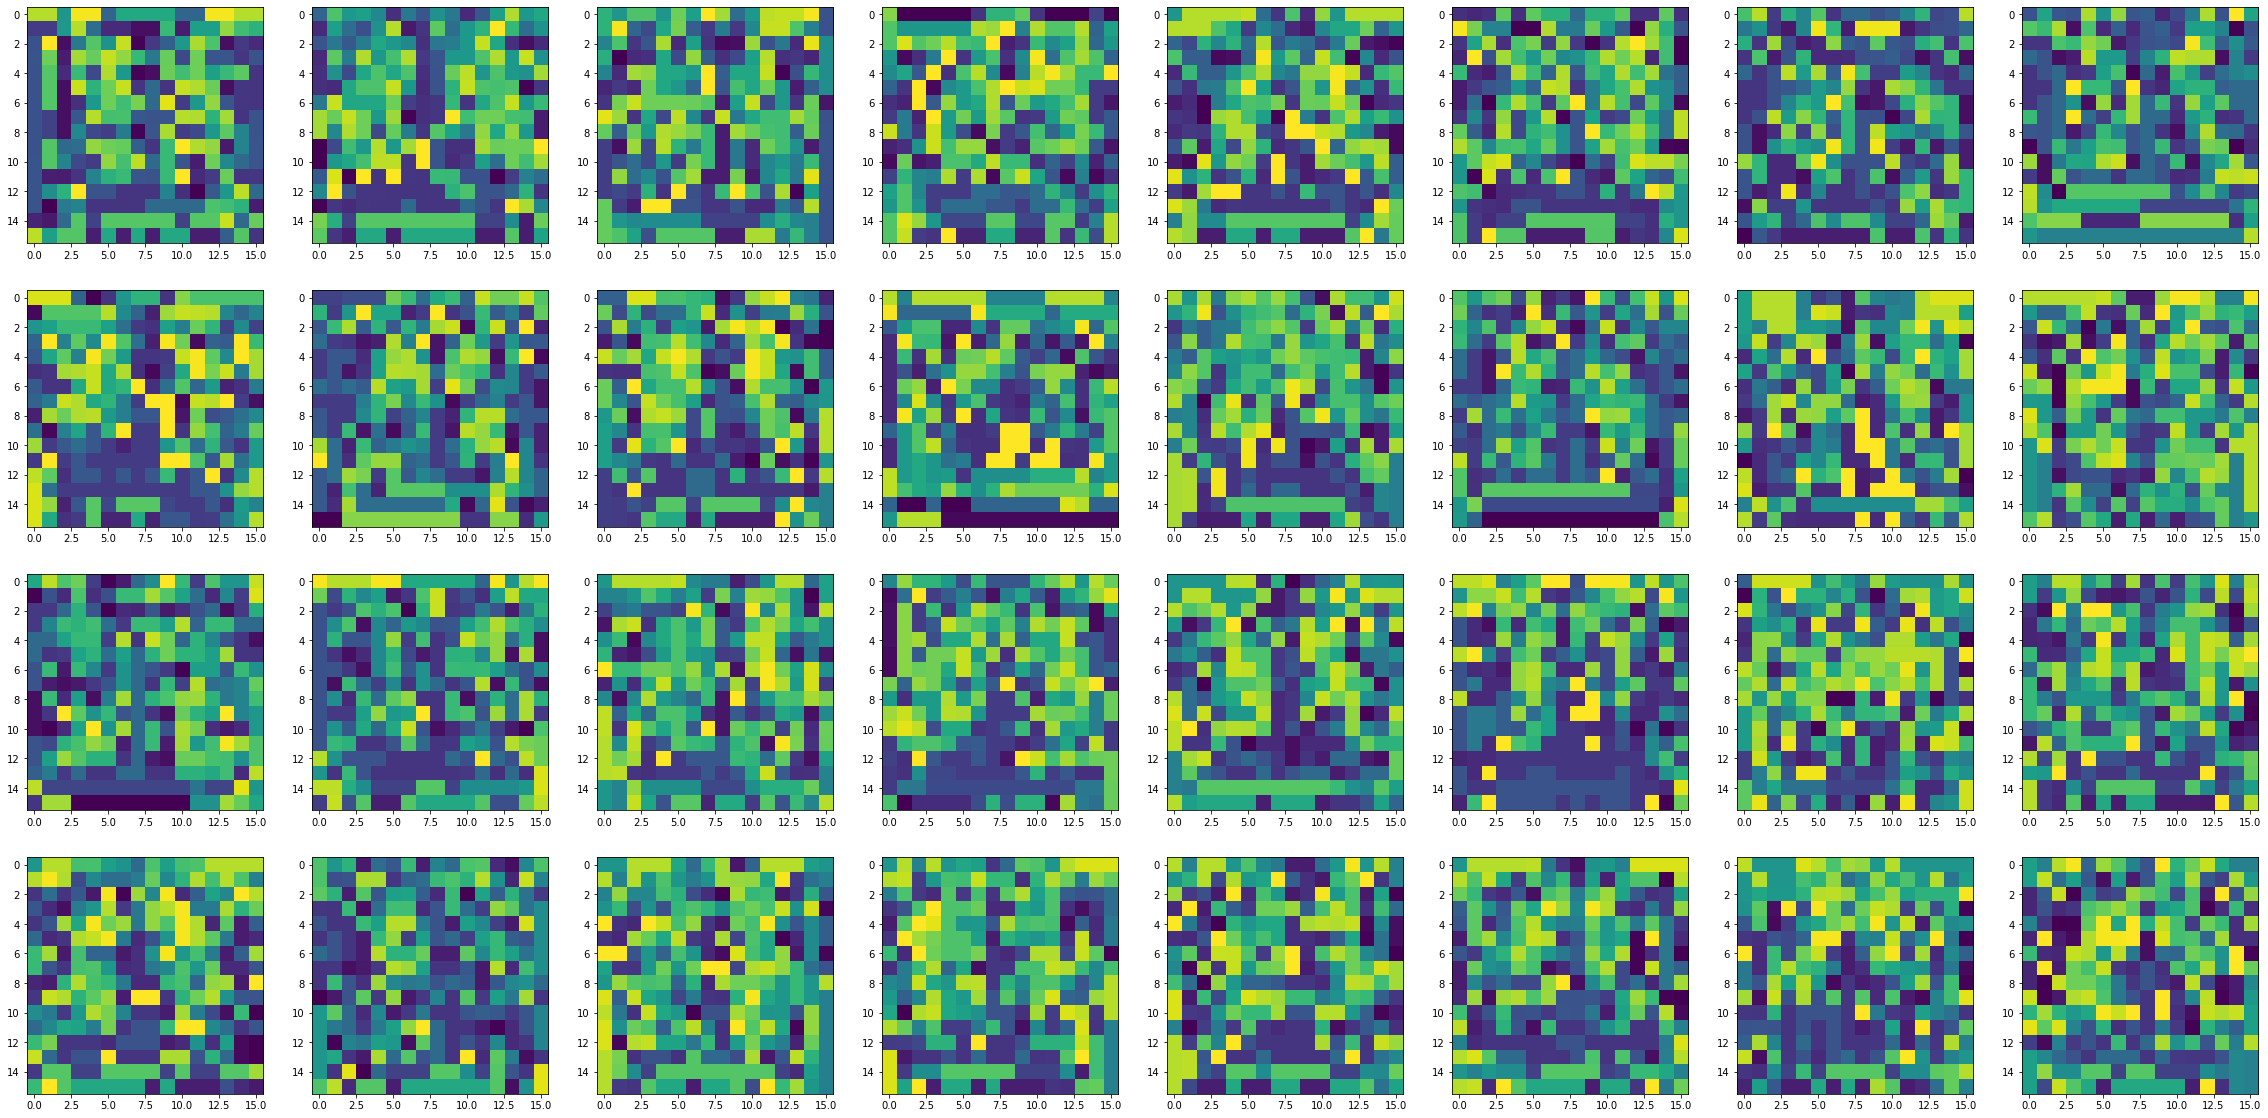

In [9]:
##### Visualise Codes ##############################################################################################

fig = plt.figure(figsize=(40, 20))

rnd_idx = np.random.choice(z_test.shape[0], size=[32], replace=False)
for i in tqdm.tqdm(range(32)):
    ax = fig.add_subplot(4, 8, i + 1)
    img = ax.imshow(np.squeeze(z_train[rnd_idx[i],...]))


In [10]:
##### PixelCNN #########################################################################################################

# References:
# https://www.kaggle.com/ameroyer/keras-vq-vae-for-image-generation
# https://github.com/anantzoid/Conditional-PixelCNN-decoder/blob/master/layers.py
# https://github.com/ritheshkumar95/pytorch-vqvae

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


def split_heads(x, batch_size, num_heads, depth):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, num_heads, depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])


# def gate(inputs, multi_head=False):
#     """Attention Gated activations"""
#     q, k, v = tf.split(inputs, 3, axis=-1)
#
#     batch_size = tf.shape(inputs)[0]
#     d_model = inputs.shape[3] // 3
#     s = inputs.shape
#
#     if multi_head:
#         num_heads = 8
#         depth = d_model // num_heads
#         q = split_heads(q, batch_size, num_heads, depth)  # (batch_size, num_heads, seq_len_q, depth)
#         k = split_heads(k, batch_size, num_heads, depth)  # (batch_size, num_heads, seq_len_k, depth)
#         v = split_heads(v, batch_size, num_heads, depth)  # (batch_size, num_heads, seq_len_v, depth)
#     else:
#         q = tf.reshape(q, (batch_size, s[1] * s[2], d_model))
#         k = tf.reshape(k, (batch_size, s[1] * s[2], d_model))
#         v = tf.reshape(v, (batch_size, s[1] * s[2], d_model))
#
#     scaled_attention, _ = scaled_dot_product_attention(q, k, v, None)
#
#     if multi_head:
#         scaled_attention = tf.transpose(scaled_attention,
#                                         perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
#
#     output = tf.reshape(scaled_attention, (batch_size, s[1], s[2], d_model))
#     return output


def gate(inputs):
    """Gated activations"""
    x, y = tf.split(inputs, 2, axis=-1)
    return tf.tanh(x) * tf.sigmoid(y)


class MaskedConv2D(tf.keras.layers.Layer):
    """Masked convolution"""

    def __init__(self, kernel_size, out_dim, direction, mode, **kwargs):
        self.direction = direction  # Horizontal or vertical
        self.mode = mode  # Mask type "a" or "b"
        self.kernel_size = kernel_size
        self.out_dim = out_dim
        super(MaskedConv2D, self).__init__(**kwargs)

    def build(self, input_shape):
        filter_mid_y = self.kernel_size[0] // 2
        filter_mid_x = self.kernel_size[1] // 2
        in_dim = int(input_shape[-1])
        w_shape = [self.kernel_size[0], self.kernel_size[1], in_dim, self.out_dim]
        mask_filter = np.ones(w_shape, dtype=np.float32)
        # Build the mask
        if self.direction == "h":
            mask_filter[filter_mid_y + 1:, :, :, :] = 0.
            mask_filter[filter_mid_y, filter_mid_x + 1:, :, :] = 0.
        elif self.direction == "v":
            if self.mode == 'a':
                mask_filter[filter_mid_y:, :, :, :] = 0.
            elif self.mode == 'b':
                mask_filter[filter_mid_y + 1:, :, :, :] = 0.0
        if self.mode == 'a':
            mask_filter[filter_mid_y, filter_mid_x, :, :] = 0.0
        # Create convolution layer parameters with masked kernel
        self.W = mask_filter * self.add_weight("W_{}".format(self.direction), w_shape, trainable=True)
        self.b = self.add_weight("v_b", [self.out_dim, ], trainable=True)

    def call(self, inputs):
        return tf.keras.backend.conv2d(inputs, self.W, strides=(1, 1)) + self.b


def gated_masked_conv2d(v_stack_in, h_stack_in, out_dim, kernel, mask='b', residual=True, i=0):
    """Basic Gated-PixelCNN block.
       This is an improvement over PixelRNN to avoid "blind spots", i.e. pixels missingt from the
       field of view. It works by having two parallel stacks, for the vertical and horizontal direction,
       each being masked  to only see the appropriate context pixels.
    """
    kernel_size = (kernel // 2 + 1, kernel)
    padding = (kernel // 2, kernel // 2)

    v_stack = tf.keras.layers.ZeroPadding2D(padding=padding, name="v_pad_{}".format(i))(v_stack_in)
    v_stack = MaskedConv2D(kernel_size, out_dim * 2, "v", mask, name="v_masked_conv_{}".format(i))(v_stack)
    v_stack = v_stack[:, :int(v_stack_in.get_shape()[-3]), :, :]
    v_stack_out = tf.keras.layers.Lambda(lambda inputs: gate(inputs), name="v_gate_{}".format(i))(v_stack)

    kernel_size = (1, kernel // 2 + 1)
    padding = (0, kernel // 2)
    h_stack = tf.keras.layers.ZeroPadding2D(padding=padding, name="h_pad_{}".format(i))(h_stack_in)
    h_stack = MaskedConv2D(kernel_size, out_dim * 2, "h", mask, name="h_masked_conv_{}".format(i))(h_stack)
    h_stack = h_stack[:, :, :int(h_stack_in.get_shape()[-2]), :]
    h_stack_1 = tf.keras.layers.Conv2D(filters=out_dim * 2, kernel_size=1, strides=(1, 1), name="v_to_h_{}".format(i))(v_stack)
    h_stack_out = tf.keras.layers.Lambda(lambda inputs: gate(inputs), name="h_gate_{}".format(i))(h_stack + h_stack_1)

    h_stack_out = tf.keras.layers.Conv2D(filters=out_dim, kernel_size=1, strides=(1, 1), name="res_conv_{}".format(i))(
        h_stack_out)
    if residual:
        h_stack_out += h_stack_in
    return v_stack_out, h_stack_out


In [11]:
##### PixelCNN Prior Network ###########################################################################################

pixelcnn_prior_inputs = tf.keras.layers.Input(shape=(SIZE, SIZE), name='pixelcnn_prior_inputs', dtype=tf.int32)
z_q = model.vq_vae.quantize_encoding(pixelcnn_prior_inputs)  # maps indices to the actual codebook

v_stack_in, h_stack_in = z_q, z_q
for i in range(PIXELCNN_NUM_BLOCKS):
    mask = 'b' if i > 0 else 'a'
    kernel_size = 3 if i > 0 else 7
    residual = True if i > 0 else False
    v_stack_in, h_stack_in = gated_masked_conv2d(v_stack_in, h_stack_in, PIXELCNN_NUM_FEATURE_MAPS,
                                                 kernel=kernel_size, residual=residual, i=i + 1)

fc1 = tf.keras.layers.Conv2D(filters=PIXELCNN_NUM_FEATURE_MAPS, kernel_size=1, name="fc1")(h_stack_in)
fc2 = tf.keras.layers.Conv2D(filters=NUM_LATENT_K, kernel_size=1, name="fc2")(fc1)
# outputs logits for probabilities of codebook indices for each cell

pixelcnn_prior = tf.keras.Model(inputs=pixelcnn_prior_inputs, outputs=fc2, name='pixelcnn-prior')

# Distribution to sample from the pixelcnn
samples = tfp.distributions.Categorical(logits=fc2).sample()
prior_sampler = tf.keras.Model(inputs=pixelcnn_prior_inputs, outputs=samples, name='pixelcnn-prior-sampler')


In [12]:
##### Train PixelCNN Prior Network #####################################################################################

pixelcnn_prior.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=tf.keras.metrics.SparseCategoricalAccuracy(),
                       optimizer=tf.keras.optimizers.Adam(PIXELCNN_LEARNING_RATE))

prior_history = pixelcnn_prior.fit(z_train, z_train,
                                   epochs=PIXELCNN_NUM_EPOCHS,
                                   batch_size=PIXELCNN_BATCH_SIZE,
                                   validation_data=(z_val, z_val),
                                   verbose=1)


Epoch 1/500
34/34 [==============================] - 21s 291ms/step - loss: 5.4276 - sparse_categorical_accuracy: 0.0377 - val_loss: 4.5102 - val_sparse_categorical_accuracy: 0.0756
Epoch 2/500
34/34 [==============================] - 8s 238ms/step - loss: 4.1615 - sparse_categorical_accuracy: 0.0807 - val_loss: 3.9109 - val_sparse_categorical_accuracy: 0.0952
Epoch 3/500
34/34 [==============================] - 8s 238ms/step - loss: 3.8041 - sparse_categorical_accuracy: 0.0974 - val_loss: 3.6987 - val_sparse_categorical_accuracy: 0.1093
Epoch 4/500
34/34 [==============================] - 8s 239ms/step - loss: 3.6503 - sparse_categorical_accuracy: 0.1104 - val_loss: 3.5807 - val_sparse_categorical_accuracy: 0.1203
Epoch 5/500
34/34 [==============================] - 8s 239ms/step - loss: 3.5393 - sparse_categorical_accuracy: 0.1239 - val_loss: 3.4794 - val_sparse_categorical_accuracy: 0.1329
Epoch 6/500
34/34 [==============================] - 8s 240ms/step - loss: 3.4525 - sparse_cat

Epoch 18/500
34/34 [==============================] - 9s 251ms/step - loss: 2.9708 - sparse_categorical_accuracy: 0.2005 - val_loss: 2.9445 - val_sparse_categorical_accuracy: 0.2009
Epoch 19/500
34/34 [==============================] - 9s 252ms/step - loss: 2.9544 - sparse_categorical_accuracy: 0.2031 - val_loss: 2.9187 - val_sparse_categorical_accuracy: 0.2063
Epoch 20/500
34/34 [==============================] - 9s 255ms/step - loss: 2.9345 - sparse_categorical_accuracy: 0.2061 - val_loss: 2.9107 - val_sparse_categorical_accuracy: 0.2062
Epoch 21/500
34/34 [==============================] - 9s 255ms/step - loss: 2.9247 - sparse_categorical_accuracy: 0.2069 - val_loss: 2.8988 - val_sparse_categorical_accuracy: 0.2096
Epoch 22/500
34/34 [==============================] - 9s 258ms/step - loss: 2.9098 - sparse_categorical_accuracy: 0.2097 - val_loss: 2.8891 - val_sparse_categorical_accuracy: 0.2082
Epoch 23/500
34/34 [==============================] - 9s 260ms/step - loss: 2.8980 - spars

34/34 [==============================] - 10s 280ms/step - loss: 2.6543 - sparse_categorical_accuracy: 0.2529 - val_loss: 2.6411 - val_sparse_categorical_accuracy: 0.2535
Epoch 64/500
34/34 [==============================] - 10s 281ms/step - loss: 2.6507 - sparse_categorical_accuracy: 0.2536 - val_loss: 2.6399 - val_sparse_categorical_accuracy: 0.2543
Epoch 65/500
34/34 [==============================] - 10s 281ms/step - loss: 2.6461 - sparse_categorical_accuracy: 0.2545 - val_loss: 2.6401 - val_sparse_categorical_accuracy: 0.2538
Epoch 66/500
34/34 [==============================] - 10s 281ms/step - loss: 2.6450 - sparse_categorical_accuracy: 0.2548 - val_loss: 2.6529 - val_sparse_categorical_accuracy: 0.2514
Epoch 67/500
34/34 [==============================] - 10s 280ms/step - loss: 2.6441 - sparse_categorical_accuracy: 0.2542 - val_loss: 2.6537 - val_sparse_categorical_accuracy: 0.2500
Epoch 68/500
34/34 [==============================] - 10s 281ms/step - loss: 2.6433 - sparse_categ

Epoch 108/500
34/34 [==============================] - 9s 269ms/step - loss: 2.5621 - sparse_categorical_accuracy: 0.2689 - val_loss: 2.5661 - val_sparse_categorical_accuracy: 0.2670
Epoch 109/500
34/34 [==============================] - 9s 268ms/step - loss: 2.5588 - sparse_categorical_accuracy: 0.2697 - val_loss: 2.5557 - val_sparse_categorical_accuracy: 0.2699
Epoch 110/500
34/34 [==============================] - 9s 266ms/step - loss: 2.5573 - sparse_categorical_accuracy: 0.2699 - val_loss: 2.5645 - val_sparse_categorical_accuracy: 0.2682
Epoch 111/500
34/34 [==============================] - 9s 268ms/step - loss: 2.5572 - sparse_categorical_accuracy: 0.2702 - val_loss: 2.5685 - val_sparse_categorical_accuracy: 0.2678
Epoch 112/500
34/34 [==============================] - 9s 269ms/step - loss: 2.5533 - sparse_categorical_accuracy: 0.2707 - val_loss: 2.5572 - val_sparse_categorical_accuracy: 0.2680
Epoch 113/500
34/34 [==============================] - 9s 268ms/step - loss: 2.5540 -

Epoch 153/500
34/34 [==============================] - 9s 267ms/step - loss: 2.5040 - sparse_categorical_accuracy: 0.2797 - val_loss: 2.5117 - val_sparse_categorical_accuracy: 0.2784
Epoch 154/500
34/34 [==============================] - 9s 266ms/step - loss: 2.5041 - sparse_categorical_accuracy: 0.2795 - val_loss: 2.5314 - val_sparse_categorical_accuracy: 0.2721
Epoch 155/500
34/34 [==============================] - 9s 267ms/step - loss: 2.5071 - sparse_categorical_accuracy: 0.2787 - val_loss: 2.5144 - val_sparse_categorical_accuracy: 0.2767
Epoch 156/500
34/34 [==============================] - 9s 268ms/step - loss: 2.5107 - sparse_categorical_accuracy: 0.2779 - val_loss: 2.5108 - val_sparse_categorical_accuracy: 0.2773
Epoch 157/500
34/34 [==============================] - 9s 268ms/step - loss: 2.5051 - sparse_categorical_accuracy: 0.2787 - val_loss: 2.5156 - val_sparse_categorical_accuracy: 0.2772
Epoch 158/500
34/34 [==============================] - 9s 268ms/step - loss: 2.5005 -

Epoch 198/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4726 - sparse_categorical_accuracy: 0.2849 - val_loss: 2.4833 - val_sparse_categorical_accuracy: 0.2837
Epoch 199/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4674 - sparse_categorical_accuracy: 0.2862 - val_loss: 2.4877 - val_sparse_categorical_accuracy: 0.2824
Epoch 200/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4659 - sparse_categorical_accuracy: 0.2865 - val_loss: 2.4817 - val_sparse_categorical_accuracy: 0.2843
Epoch 201/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4659 - sparse_categorical_accuracy: 0.2864 - val_loss: 2.4840 - val_sparse_categorical_accuracy: 0.2834
Epoch 202/500
34/34 [==============================] - 9s 265ms/step - loss: 2.4668 - sparse_categorical_accuracy: 0.2861 - val_loss: 2.4796 - val_sparse_categorical_accuracy: 0.2851
Epoch 203/500
34/34 [==============================] - 9s 265ms/step - loss: 2.4642 -

Epoch 243/500
34/34 [==============================] - 9s 267ms/step - loss: 2.4419 - sparse_categorical_accuracy: 0.2907 - val_loss: 2.4602 - val_sparse_categorical_accuracy: 0.2878
Epoch 244/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4377 - sparse_categorical_accuracy: 0.2917 - val_loss: 2.4689 - val_sparse_categorical_accuracy: 0.2872
Epoch 245/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4407 - sparse_categorical_accuracy: 0.2907 - val_loss: 2.4695 - val_sparse_categorical_accuracy: 0.2853
Epoch 246/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4368 - sparse_categorical_accuracy: 0.2918 - val_loss: 2.4608 - val_sparse_categorical_accuracy: 0.2880
Epoch 247/500
34/34 [==============================] - 9s 266ms/step - loss: 2.4397 - sparse_categorical_accuracy: 0.2910 - val_loss: 2.4601 - val_sparse_categorical_accuracy: 0.2872
Epoch 248/500
34/34 [==============================] - 9s 267ms/step - loss: 2.4387 -

Epoch 288/500
34/34 [==============================] - 9s 264ms/step - loss: 2.4164 - sparse_categorical_accuracy: 0.2956 - val_loss: 2.4649 - val_sparse_categorical_accuracy: 0.2862
Epoch 289/500
34/34 [==============================] - 9s 264ms/step - loss: 2.4181 - sparse_categorical_accuracy: 0.2949 - val_loss: 2.4447 - val_sparse_categorical_accuracy: 0.2902
Epoch 290/500
34/34 [==============================] - 9s 265ms/step - loss: 2.4173 - sparse_categorical_accuracy: 0.2950 - val_loss: 2.4433 - val_sparse_categorical_accuracy: 0.2906
Epoch 291/500
34/34 [==============================] - 9s 265ms/step - loss: 2.4167 - sparse_categorical_accuracy: 0.2952 - val_loss: 2.4571 - val_sparse_categorical_accuracy: 0.2881
Epoch 292/500
34/34 [==============================] - 9s 264ms/step - loss: 2.4170 - sparse_categorical_accuracy: 0.2954 - val_loss: 2.4532 - val_sparse_categorical_accuracy: 0.2878
Epoch 293/500
34/34 [==============================] - 9s 264ms/step - loss: 2.4158 -

Epoch 333/500
34/34 [==============================] - 9s 265ms/step - loss: 2.3958 - sparse_categorical_accuracy: 0.2994 - val_loss: 2.4298 - val_sparse_categorical_accuracy: 0.2939
Epoch 334/500
34/34 [==============================] - 9s 265ms/step - loss: 2.3967 - sparse_categorical_accuracy: 0.2993 - val_loss: 2.4392 - val_sparse_categorical_accuracy: 0.2923
Epoch 335/500
34/34 [==============================] - 9s 265ms/step - loss: 2.3958 - sparse_categorical_accuracy: 0.2995 - val_loss: 2.4359 - val_sparse_categorical_accuracy: 0.2928
Epoch 336/500
34/34 [==============================] - 9s 264ms/step - loss: 2.3989 - sparse_categorical_accuracy: 0.2987 - val_loss: 2.4380 - val_sparse_categorical_accuracy: 0.2919
Epoch 337/500
34/34 [==============================] - 9s 264ms/step - loss: 2.3976 - sparse_categorical_accuracy: 0.2988 - val_loss: 2.4297 - val_sparse_categorical_accuracy: 0.2930
Epoch 338/500
34/34 [==============================] - 9s 263ms/step - loss: 2.3948 -

Epoch 378/500
34/34 [==============================] - 9s 259ms/step - loss: 2.3832 - sparse_categorical_accuracy: 0.3013 - val_loss: 2.4186 - val_sparse_categorical_accuracy: 0.2950
Epoch 379/500
34/34 [==============================] - 9s 260ms/step - loss: 2.3814 - sparse_categorical_accuracy: 0.3018 - val_loss: 2.4231 - val_sparse_categorical_accuracy: 0.2946
Epoch 380/500
34/34 [==============================] - 9s 262ms/step - loss: 2.3801 - sparse_categorical_accuracy: 0.3021 - val_loss: 2.4238 - val_sparse_categorical_accuracy: 0.2946
Epoch 381/500
34/34 [==============================] - 9s 262ms/step - loss: 2.3811 - sparse_categorical_accuracy: 0.3017 - val_loss: 2.4344 - val_sparse_categorical_accuracy: 0.2913
Epoch 382/500
34/34 [==============================] - 9s 260ms/step - loss: 2.3821 - sparse_categorical_accuracy: 0.3018 - val_loss: 2.4187 - val_sparse_categorical_accuracy: 0.2960
Epoch 383/500
34/34 [==============================] - 9s 260ms/step - loss: 2.3775 -

Epoch 423/500
34/34 [==============================] - 9s 259ms/step - loss: 2.3659 - sparse_categorical_accuracy: 0.3051 - val_loss: 2.4215 - val_sparse_categorical_accuracy: 0.2944
Epoch 424/500
34/34 [==============================] - 9s 259ms/step - loss: 2.3687 - sparse_categorical_accuracy: 0.3040 - val_loss: 2.4151 - val_sparse_categorical_accuracy: 0.2958
Epoch 425/500
34/34 [==============================] - 9s 258ms/step - loss: 2.3648 - sparse_categorical_accuracy: 0.3050 - val_loss: 2.4109 - val_sparse_categorical_accuracy: 0.2966
Epoch 426/500
34/34 [==============================] - 9s 260ms/step - loss: 2.3655 - sparse_categorical_accuracy: 0.3045 - val_loss: 2.4087 - val_sparse_categorical_accuracy: 0.2977
Epoch 427/500
34/34 [==============================] - 9s 261ms/step - loss: 2.3620 - sparse_categorical_accuracy: 0.3058 - val_loss: 2.4065 - val_sparse_categorical_accuracy: 0.2975
Epoch 428/500
34/34 [==============================] - 9s 260ms/step - loss: 2.3638 -

Epoch 468/500
34/34 [==============================] - 9s 258ms/step - loss: 2.3548 - sparse_categorical_accuracy: 0.3066 - val_loss: 2.3982 - val_sparse_categorical_accuracy: 0.2989
Epoch 469/500
34/34 [==============================] - 9s 259ms/step - loss: 2.3540 - sparse_categorical_accuracy: 0.3068 - val_loss: 2.4004 - val_sparse_categorical_accuracy: 0.2988
Epoch 470/500
34/34 [==============================] - 9s 258ms/step - loss: 2.3508 - sparse_categorical_accuracy: 0.3075 - val_loss: 2.4018 - val_sparse_categorical_accuracy: 0.2968
Epoch 471/500
34/34 [==============================] - 9s 257ms/step - loss: 2.3510 - sparse_categorical_accuracy: 0.3077 - val_loss: 2.4041 - val_sparse_categorical_accuracy: 0.2979
Epoch 472/500
34/34 [==============================] - 9s 257ms/step - loss: 2.3507 - sparse_categorical_accuracy: 0.3077 - val_loss: 2.4037 - val_sparse_categorical_accuracy: 0.2981
Epoch 473/500
34/34 [==============================] - 9s 256ms/step - loss: 2.3518 -

Text(0, 0.5, 'sparse_categorical_accuracy')

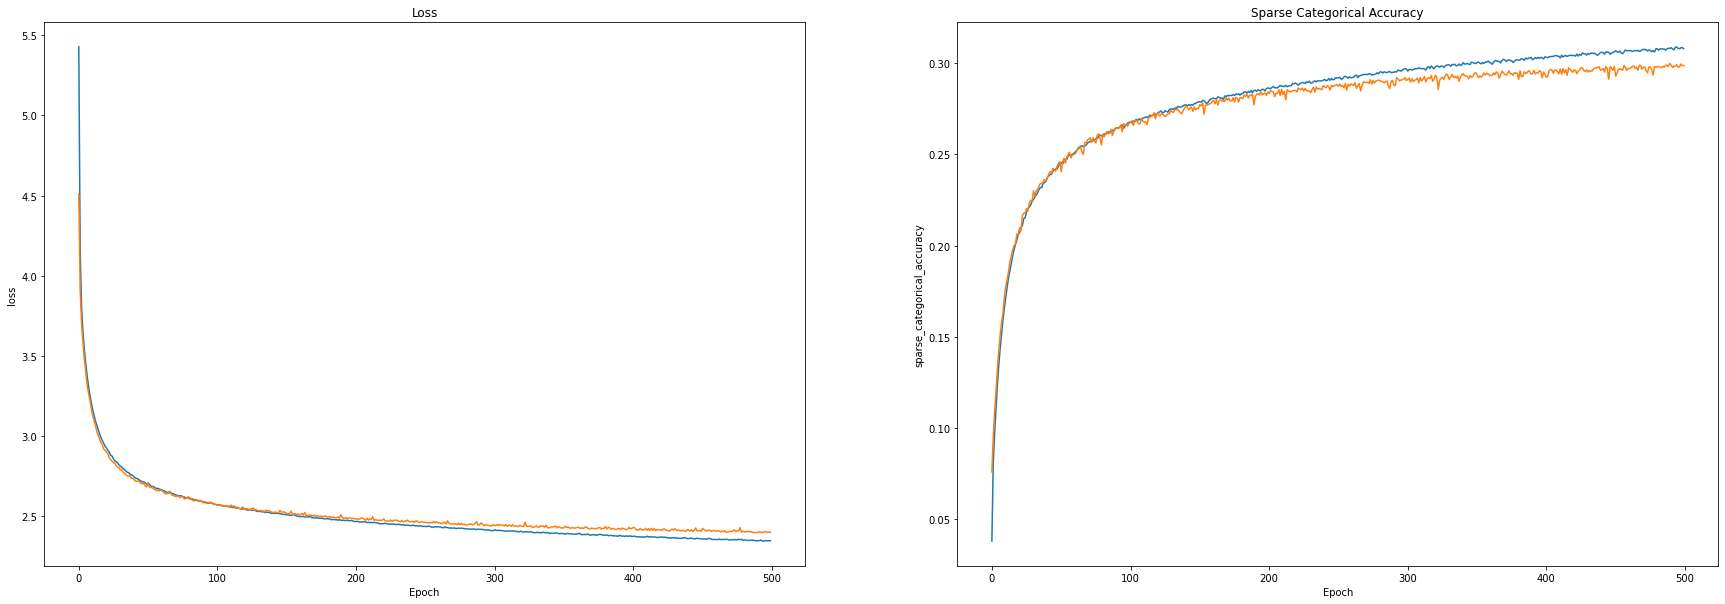

In [13]:
##### Loss and Accuracy Graphs #####################################################################################

fig=plt.figure(figsize=(30, 10))

x = np.arange(0, len(prior_history.history['loss']))
y1_train    = prior_history.history['loss']
y1_val      = prior_history.history['val_loss']
y2_train    = prior_history.history['sparse_categorical_accuracy']
y2_val      = prior_history.history['val_sparse_categorical_accuracy']

ax = fig.add_subplot(1, 2, 1)
ax.plot(x, y1_train)
ax.plot(x, y1_val)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
ax = fig.add_subplot(1, 2, 2)
ax.plot(x, y2_train)
ax.plot(x, y2_val)
ax.set_title('Sparse Categorical Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('sparse_categorical_accuracy')


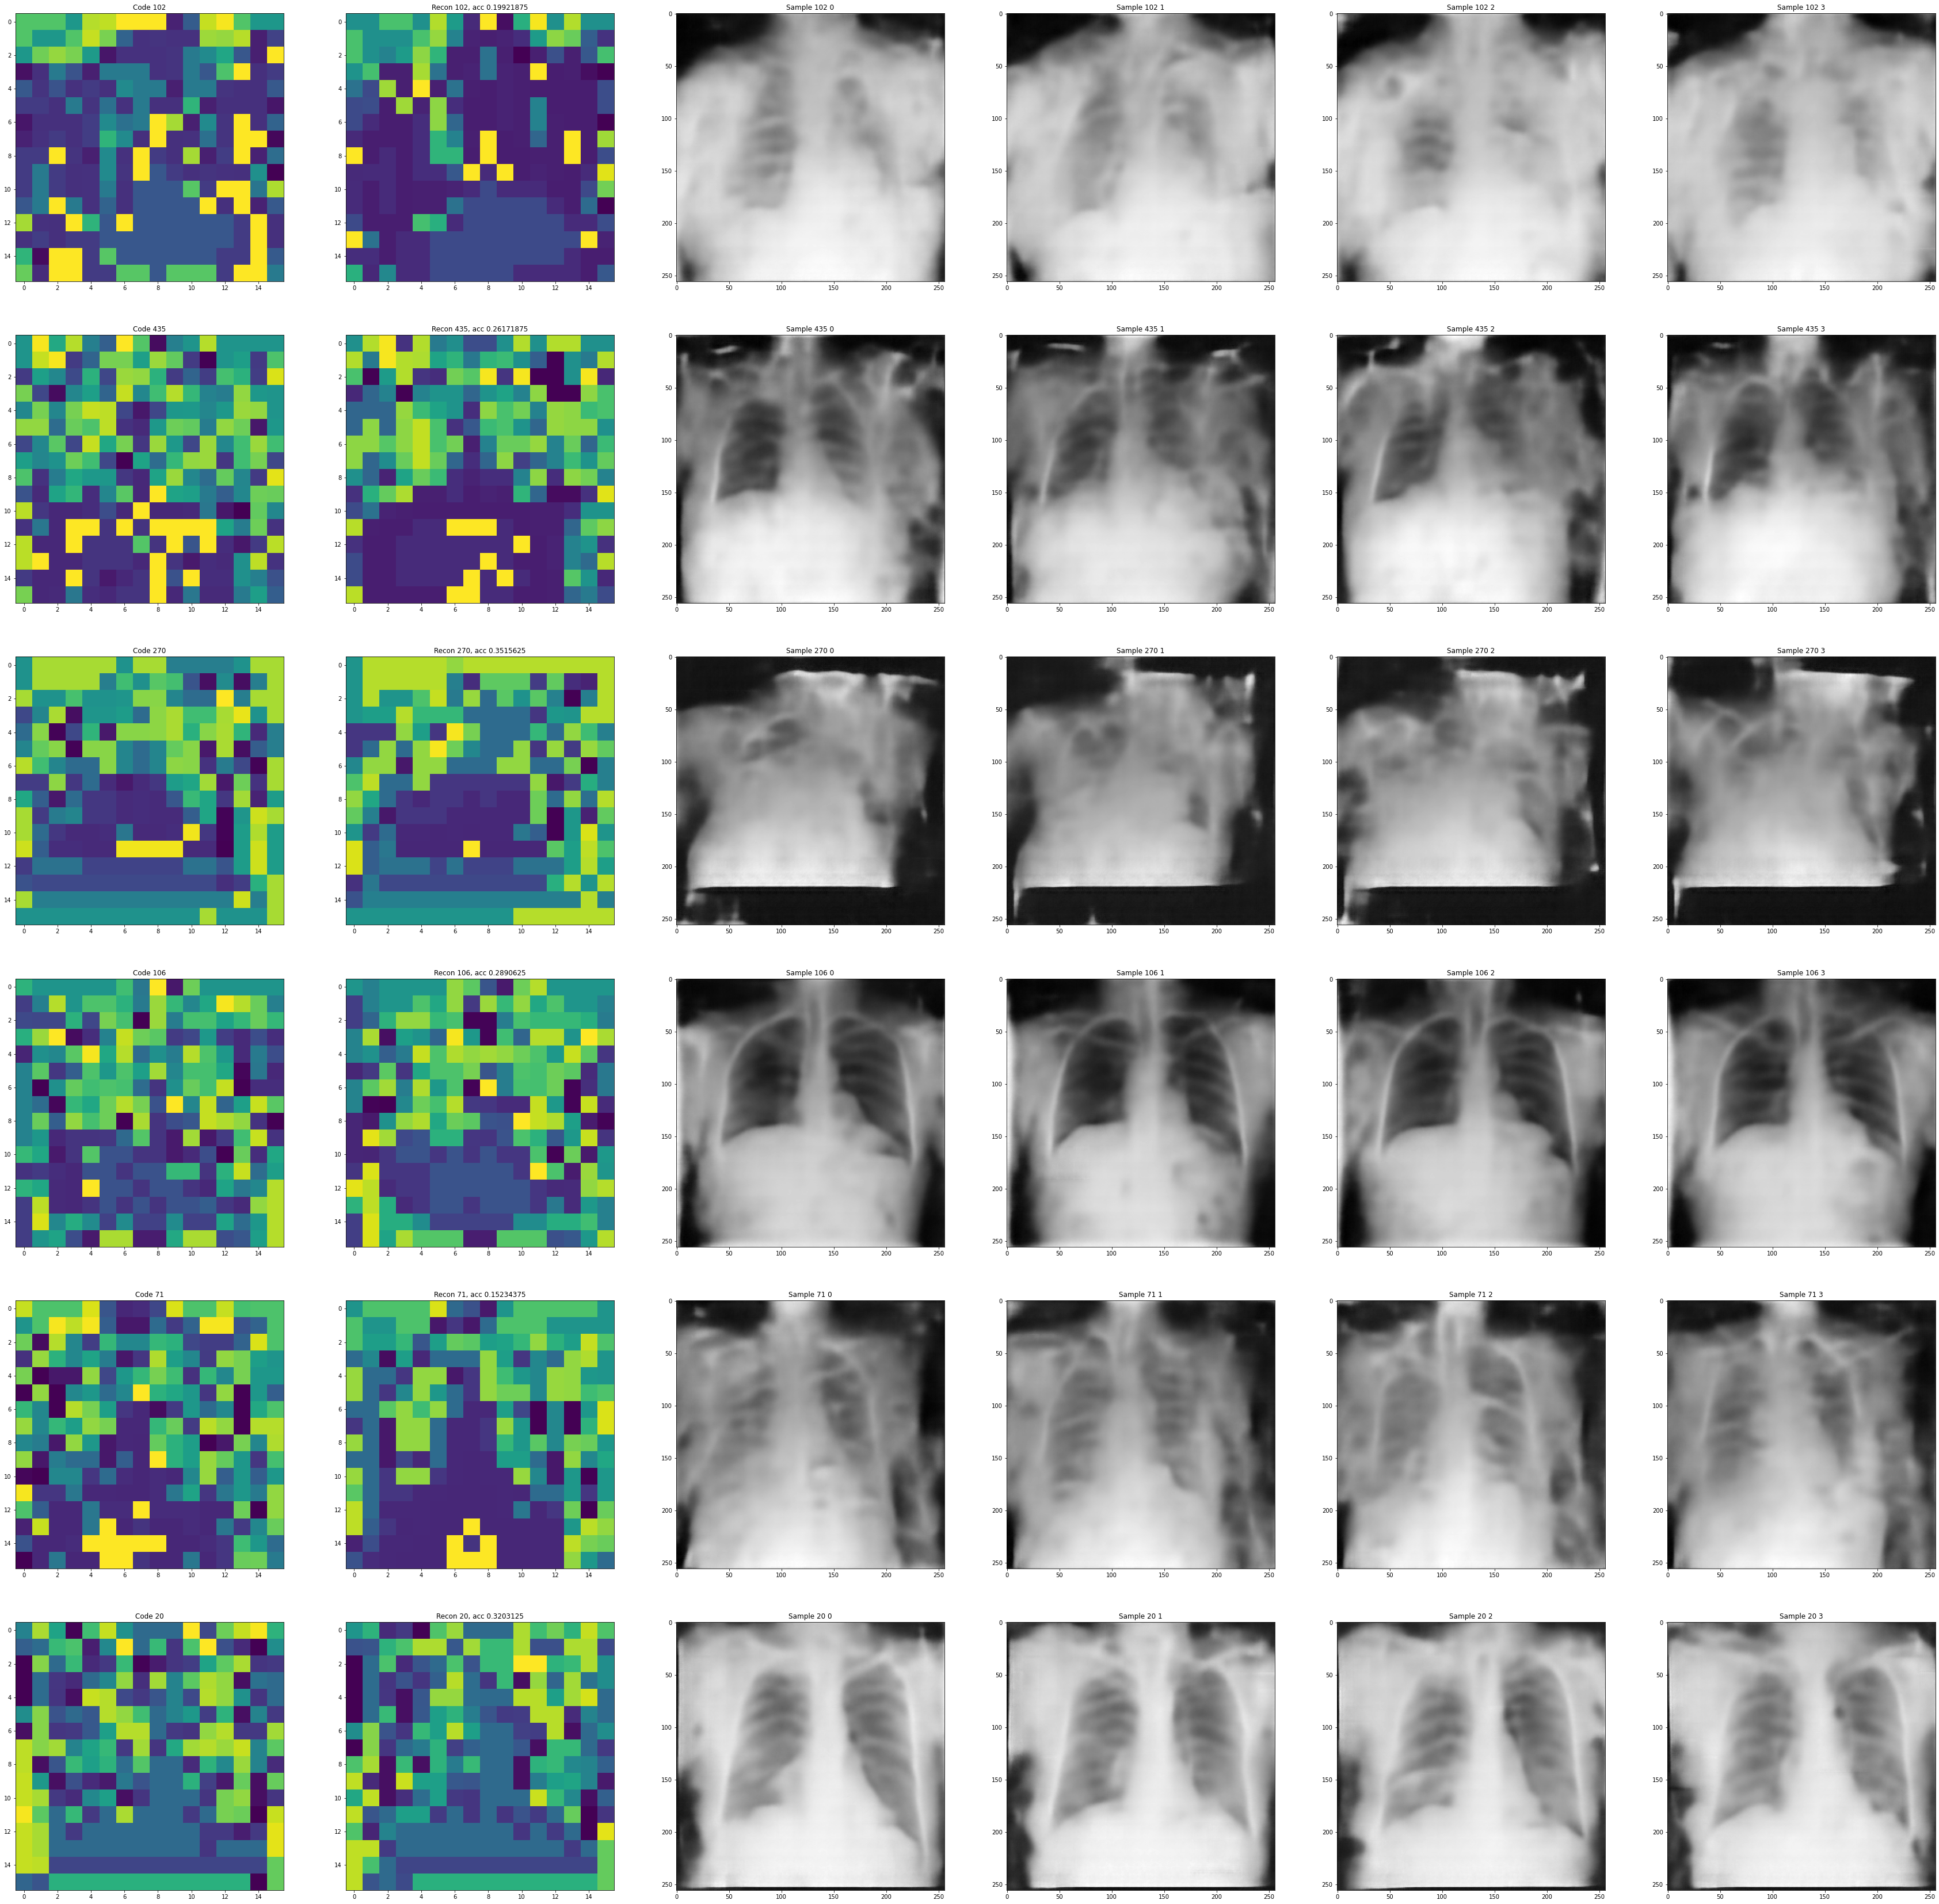

In [79]:
##### Reconstruct Code and Generate Samples ############################################################################

def get_samples(z):
    img = prior_sampler(z)
    img = model.vq_vae.quantize_encoding(img)
    X = model.decoder(img).numpy()
    X = (X - X.min()) / (X.max() - X.min()) * 255
    return X


recons = pixelcnn_prior(z_test)
recons = tf.argmax(recons, axis=-1)
accs = np.mean(np.equal(recons, z_test), axis=(1, 2))
samples0 = get_samples(z_test)
samples1 = get_samples(z_test)
samples2 = get_samples(z_test)
samples3 = get_samples(z_test)


np.random.seed(42)
sample_idx = np.random.randint(0, 667, size=(6))


fig = plt.figure(figsize=(60, 60))
for i, idx in enumerate(sample_idx):

    ax = fig.add_subplot(6, 6, 6 * i + 1)
    ax.imshow(z_test[idx,...])
    ax.set_title(f'Code {idx}')
    
    ax = fig.add_subplot(6, 6, 6 * i + 2)
    ax.imshow(recons[idx,...].numpy())
    ax.set_title(f'Recon {idx}, acc {accs[i]}')

    ax = fig.add_subplot(6, 6, 6 * i + 3)
    ax.imshow(np.squeeze(samples0[idx,...]), cmap='gray')
    ax.set_title(f'Sample {idx} {0}')
    
    ax = fig.add_subplot(6, 6, 6 * i + 4)
    ax.imshow(np.squeeze(samples1[idx,...]), cmap='gray')
    ax.set_title(f'Sample {idx} {1}')
    
    ax = fig.add_subplot(6, 6, 6 * i + 5)
    ax.imshow(np.squeeze(samples2[idx,...]), cmap='gray')
    ax.set_title(f'Sample {idx} {2}')
    
    ax = fig.add_subplot(6, 6, 6 * i + 6)
    ax.imshow(np.squeeze(samples3[idx,...]), cmap='gray')
    ax.set_title(f'Sample {idx} {3}')
